In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Discriminator

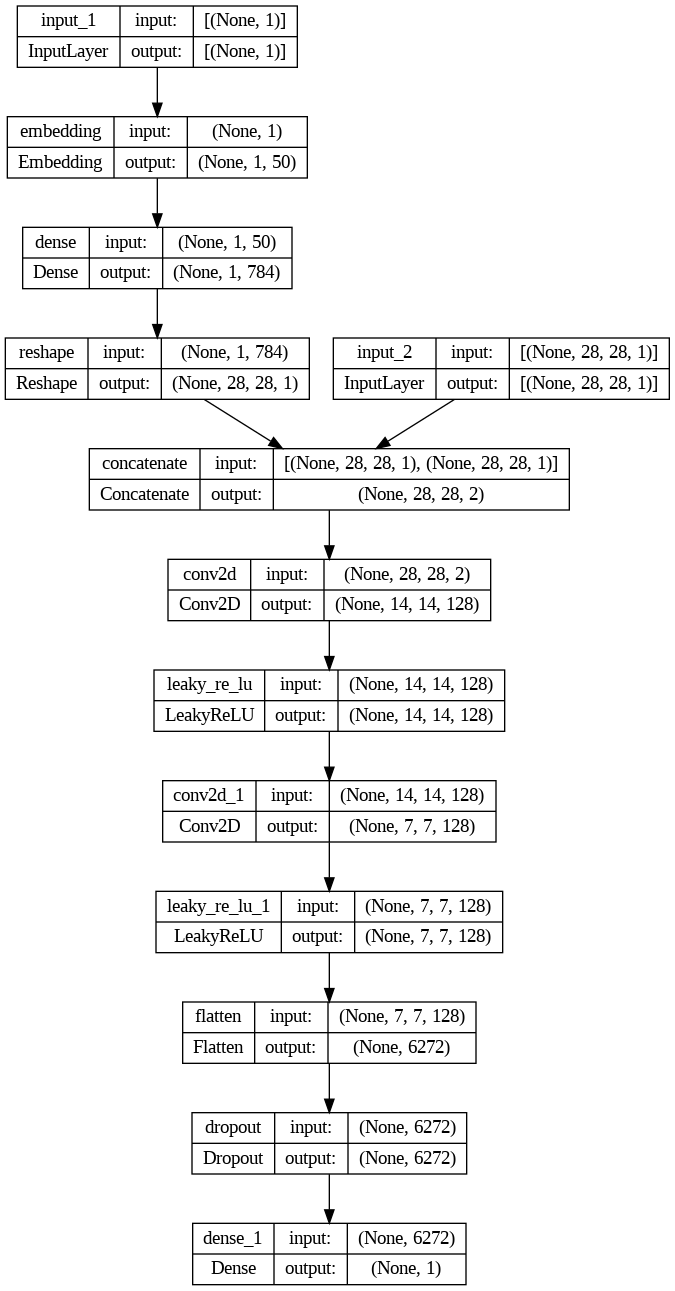

In [2]:
def define_discriminator(in_shape=(28, 28, 1), n_classes=10):
  in_label = layers.Input(shape=(1,))
  li = layers.Embedding(n_classes, 50)(in_label)
  n_nodes = in_shape[0] * in_shape[1]
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)
  in_image = layers.Input(shape=in_shape)
  merge = layers.Concatenate()([in_image, li])
  fe = layers.Conv2D(128, (3, 3), strides=2, padding='same')(merge)
  fe = layers.LeakyReLU(0.2)(fe)
  fe = layers.Conv2D(128, (3, 3), strides=2, padding='same')(fe)
  fe = layers.LeakyReLU(0.2)(fe)
  fe = layers.Flatten()(fe)
  fe = layers.Dropout(0.4)(fe)
  out_layer = layers.Dense(1, activation='sigmoid')(fe)
  model = keras.models.Model([in_image, in_label], out_layer)
  model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
  return model

discriminator = define_discriminator()
# discriminator.summary()
keras.utils.plot_model(discriminator, show_shapes=True)

## Generator

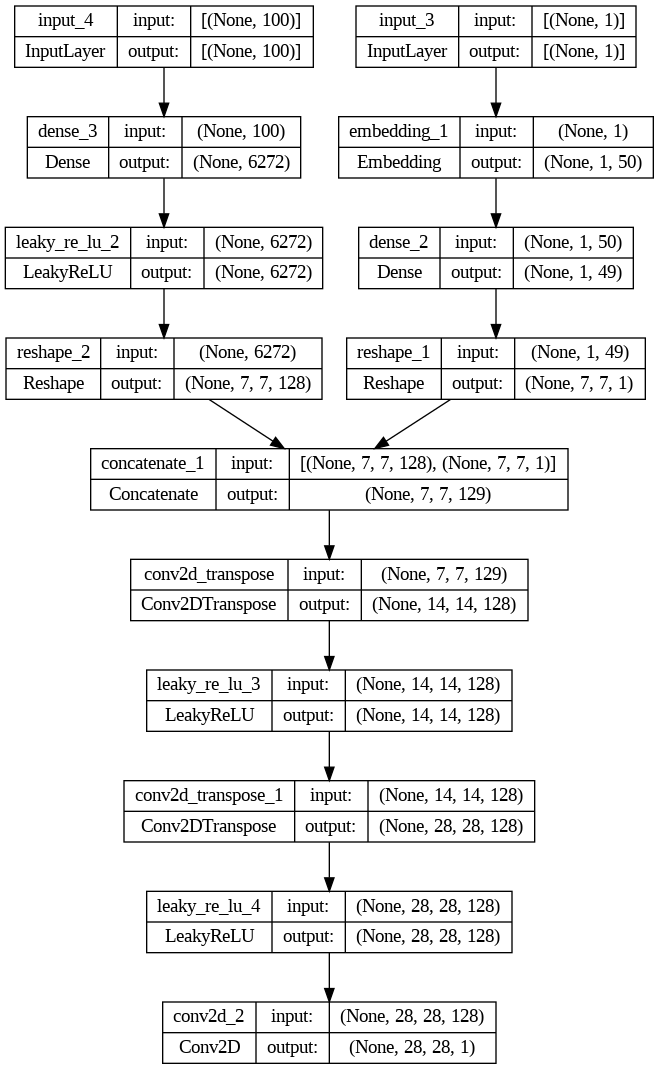

In [3]:
def define_generator(latent_dim, n_classes=10):
  in_label = layers.Input(shape=(1,))
  li = layers.Embedding(n_classes, 50)(in_label)
  n_nodes = 7 * 7
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((7, 7, 1))(li)
  in_lat = layers.Input(shape=(latent_dim,))
  n_nodes = 128 * 7 * 7
  gen = layers.Dense(n_nodes)(in_lat)
  gen = layers.LeakyReLU(0.2)(gen)
  gen = layers.Reshape((7, 7, 128))(gen)
  merge = layers.Concatenate()([gen, li])
  gen = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(merge)
  gen = layers.LeakyReLU(0.2)(gen)
  gen = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(gen)
  gen = layers.LeakyReLU(0.2)(gen)
  out_layer = layers.Conv2D(1, (7, 7), activation='tanh', padding='same')(gen)
  model = keras.Model([in_lat, in_label], out_layer)
  return model

generator = define_generator(100)
keras.utils.plot_model(generator, show_shapes=True)

## GAN

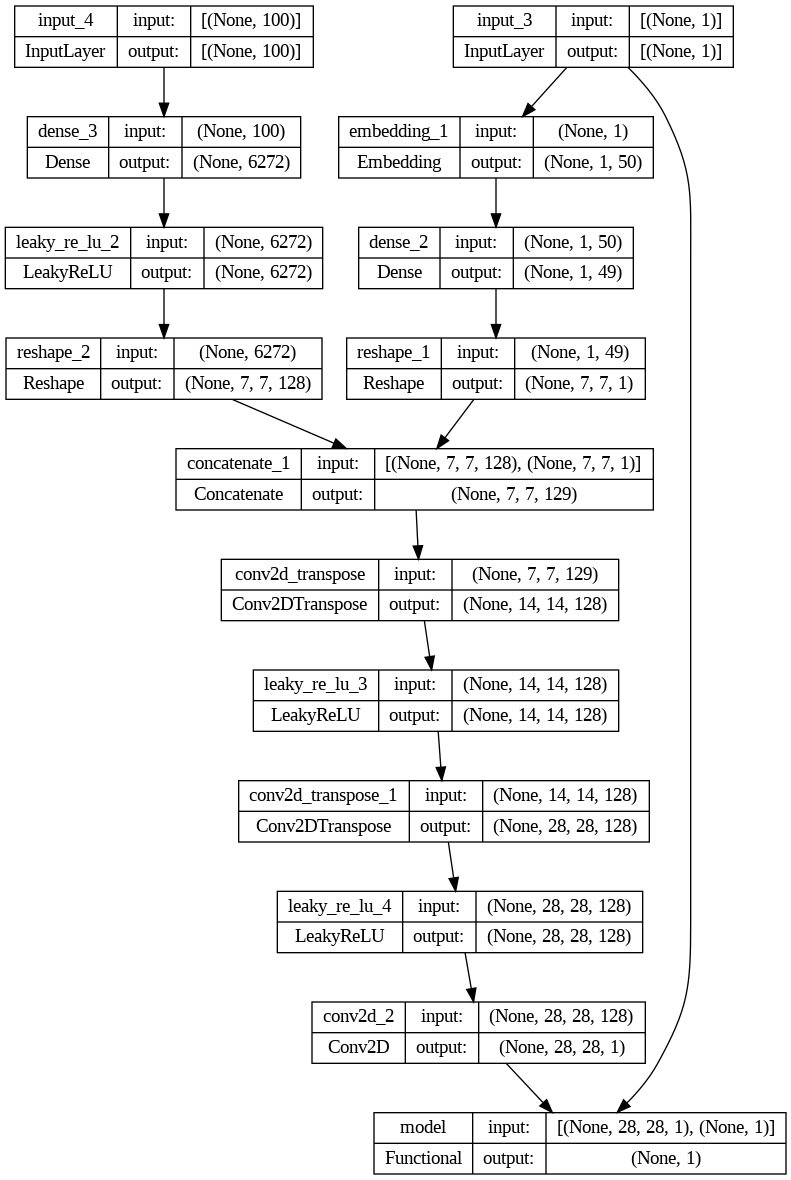

In [4]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  gen_noise, gen_label = g_model.input
  gen_output = g_model.output
  gan_output = d_model([gen_output, gen_label])
  model = keras.Model([gen_noise, gen_label], gan_output)
  model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
  return model

gan = define_gan(generator, discriminator)
keras.utils.plot_model(gan, show_shapes=True)

## Utility Functions

In [5]:
def load_real_samples():
  (x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data()
  x = np.expand_dims(x_train, axis=-1)
  x = x.astype('float32')
  x = (x - 127.5) / 127.5
  return [x, y_train]

def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = np.random.randint(0, images.shape[0], n_samples)
  x, labels = images[ix], labels[ix]
  y = np.ones((n_samples, 1))
  return [x, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = np.random.randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  images = generator.predict([z_input, labels_input])
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

## Train the GAN

In [6]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      [x_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([x_real, labels_real], y_real)
      [x_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([x_fake, labels], y_fake)
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      print('>%d, %d%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  g_model.save('cgan_generator.h5')

In [7]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 11ms/step
>5, 309468, d1=0.662, d2=0.667 g=0.740
2/2 [==============================] - 0s 8ms/step
>5, 310468, d1=0.674, d2=0.715 g=0.742
2/2 [==============================] - 0s 12ms/step
>5, 311468, d1=0.666, d2=0.695 g=0.748
2/2 [==============================] - 0s 6ms/step
>5, 312468, d1=0.663, d2=0.693 g=0.758
2/2 [==============================] - 0s 10ms/step
>5, 313468, d1=0.634, d2=0.639 g=0.795
2/2 [==============================] - 0s 5ms/step
>5, 314468, d1=0.650, d2=0.630 g=0.821
2/2 [==============================] - 0s 8ms/step
>5, 315468, d1=0.661, d2=0.623 g=0.809
2/2 [==============================] - 0s 11ms/step
>5, 316468, d1=0.676, d2=0.634 g=0.811
2/2 [==============================] - 0s 6ms/step
>5, 317468, d1=0.673, d2=0.688 g=0.763
2/2 [==============================] - 0s 11ms/step
>5, 318468, d1=0.674, d2=0.655 g=0.735
2/2 [==============================] - 0s 9m

>10, 468468, d1=0.657, d2=0.679 g=0.770


## Conditional Clothing Generation

4/4 [==============================] - 0s 49ms/step


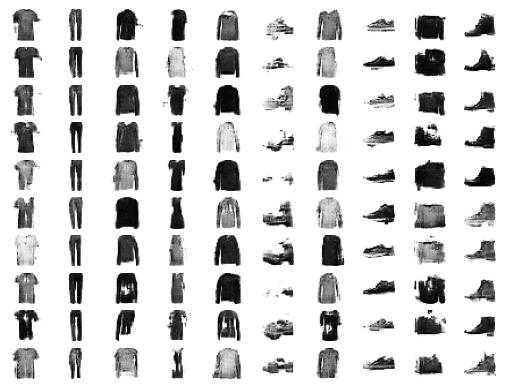

In [8]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = np.random.randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

def save_plot(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

model = keras.models.load_model('cgan_generator.h5')
latent_points, labels = generate_latent_points(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
x = model.predict([latent_points, labels])
x = (x + 1) / 2.0
save_plot(x, 10)